In [41]:
import sys
sys.path.append("../")

from CurveDataFetcher import CurveDataFetcher 
from HedgeHog import beta_estimates, calc_pca_loadings_matrix 

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import statsmodels.api as sm

from utils.pca import run_pca_yield_curve, create_residuals_surface_plot, plot_residuals_for_date
from utils.viz import plot_usts, plot_timeseries, plot_residuals_timeseries, plot_mr_residuals_timeseries, run_basic_linear_regression_df, run_basic_linear_regression

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
print(env_path)
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import matplotlib.pylab as pylab
params = {
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)
sns.set(style="whitegrid", palette="dark")
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2

c:\Users\chris\Curvy-CUSIPs\notebooks\../.env
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\chris\Curvy-CUSIPs\notebooks\..\HedgeHog.py:412: SyntaxWarning: invalid escape sequence '\e'
  pc1_beta = loadings_df.loc[y_col, "PC1"] / loadings_df.loc[x_cols[0], "PC1"]


In [9]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"])

In [10]:
tenors = ["CT3M", "CT6M", "CT1", "CT2", "CT3", "CT5", "CT7", "CT10", "CT20", "CT30"]
ct_yields_df = curve_data_fetcher.fedinvest_data_fetcher.get_historical_ct_yields(start_date=datetime(2024, 1, 1), end_date=datetime(2024, 10, 22))
ct_yields_df 

,Date,CT2M,CT3M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
0,2024-01-02,NaN,5.414579,5.266761,4.812030,4.332596,4.100865,3.930802,3.951168,3.943937,4.247731,4.083212
1,2024-01-03,NaN,5.403556,5.277076,4.822615,4.332576,4.077939,3.895921,3.914869,3.906323,4.209600,4.052949
2,2024-01-04,NaN,5.403156,5.250537,4.855018,4.382398,4.145585,3.972914,3.992895,3.988823,4.295010,4.137418
3,2024-01-05,NaN,5.391337,5.238747,4.854037,4.399235,4.178916,4.015292,4.040103,4.048999,4.363246,4.207898
4,2024-01-08,NaN,5.390940,5.227726,4.831904,4.365890,4.121773,3.966166,3.993101,4.010992,4.322075,4.176737
...,...,...,...,...,...,...,...,...,...,...,...,...
199,2024-10-16,NaN,4.663602,4.453965,4.196283,3.934877,3.841373,3.841859,3.919690,4.017476,4.366369,4.301739
200,2024-10-17,NaN,4.674115,4.474925,4.228454,3.969181,3.885924,3.898521,3.987970,4.088045,4.449309,4.387236
201,2024-10-18,NaN,4.673709,4.463719,4.206294,3.953895,3.863356,3.877784,3.967229,4.076369,4.444460,4.383404
202,2024-10-21,NaN,4.684232,4.495256,4.260034,4.022443,3.953014,3.977347,4.072880,4.179125,4.546029,4.486297


In [17]:
loadings_df, pc_scores_df = calc_pca_loadings_matrix(
    df=ct_yields_df.set_index("Date"), 
    cols=["CT3M", "CT6M", "CT1", "CT2", "CT3", "CT5", "CT7", "CT10", "CT20", "CT30"], 
    run_on_level_changes=True,
    scale_loadings=True 
)

display(loadings_df)
pc_scores_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
CT3M,-0.022717,0.066351,-0.015082,0.008794,-0.003809,0.000181,-0.000080,0.000019,0.000009,0.000011
CT6M,-0.025599,0.047488,-0.004318,-0.007463,0.009295,-0.000992,-0.000333,-0.000005,0.000024,0.000013
CT1,-0.050116,0.027291,0.013830,-0.010356,-0.007141,0.002258,0.001186,-0.000182,-0.000089,-0.000061
CT2,-0.069298,0.004619,0.022140,0.003080,-0.000480,-0.007119,0.000567,0.000174,-0.000115,-0.000101
CT3,-0.073328,-0.000550,0.016154,0.003081,0.001224,0.003355,-0.004891,0.000110,-0.000213,0.000069
CT5,-0.076355,-0.008262,0.004244,0.003682,0.002627,0.002578,0.002577,-0.001268,0.002309,0.000040
CT7,-0.074988,-0.011203,-0.003560,0.001806,0.001683,0.001785,0.002367,0.001613,-0.001597,0.001420
CT10,-0.069914,-0.013339,-0.009726,0.000459,0.000810,0.000933,0.000922,0.000815,-0.000903,-0.002151
CT20,-0.063713,-0.015934,-0.017042,-0.001930,-0.001135,-0.001605,-0.000873,-0.003165,-0.001031,0.000365
CT30,-0.060147,-0.015822,-0.020783,-0.004236,-0.002679,-0.002299,-0.001877,0.001816,0.001654,0.000367


,Date,PC1,PC2,PC3
0,2024-01-03,0.068475,-0.032155,-0.035728
1,2024-01-04,-0.192388,0.054126,0.024619
2,2024-01-05,-0.116308,0.050590,0.043997
3,2024-01-08,0.114348,-0.020842,0.003259
4,2024-01-09,-0.014435,0.008525,-0.012858
...,...,...,...,...
198,2024-10-16,0.033486,-0.019232,0.003303
199,2024-10-17,-0.169115,0.017094,0.046877
200,2024-10-18,0.043875,-0.000680,0.013390
201,2024-10-21,-0.259514,0.023126,0.029231


In [91]:
rbe = beta_estimates(df=ct_yields_df, x_cols=["CT2", "CT10"], y_col="CT5", run_on_level_changes=True, pc_scores_df=pc_scores_df, loadings_df=loadings_df)
rbe["pc_exposures"]

c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


{'pcr_pc1_exposure': -0.06935148111182514,
 'pcr_pc2_exposure': 0.08566286412789229,
 'pcr_pc3_exposure': 0.08700853837589924,
 'epsilon_pc1_loadings_exposure': -0.006748924463608988,
 'epsilon_pc2_loadings_exposure': -0.0039021018482085492,
 'epsilon_pc3_loadings_exposure': -0.001963050010748716}

In [37]:
print(rbe[1]["ols"].summary())

                            OLS Regression Results                            
Dep. Variable:                    CT5   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.067e+04
Date:                Sat, 26 Oct 2024   Prob (F-statistic):          5.94e-204
Time:                        23:27:48   Log-Likelihood:                 707.42
No. Observations:                 203   AIC:                            -1409.
Df Residuals:                     200   BIC:                            -1399.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.355e-05      0.001      0.159      0.8

                            OLS Regression Results                            
Dep. Variable:                   CT30   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     1799.
Date:                Sat, 26 Oct 2024   Prob (F-statistic):          1.54e-102
Time:                        22:40:20   Log-Likelihood:                 270.93
No. Observations:                 204   AIC:                            -537.9
Df Residuals:                     202   BIC:                            -531.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0525      0.055     37.355      0.0

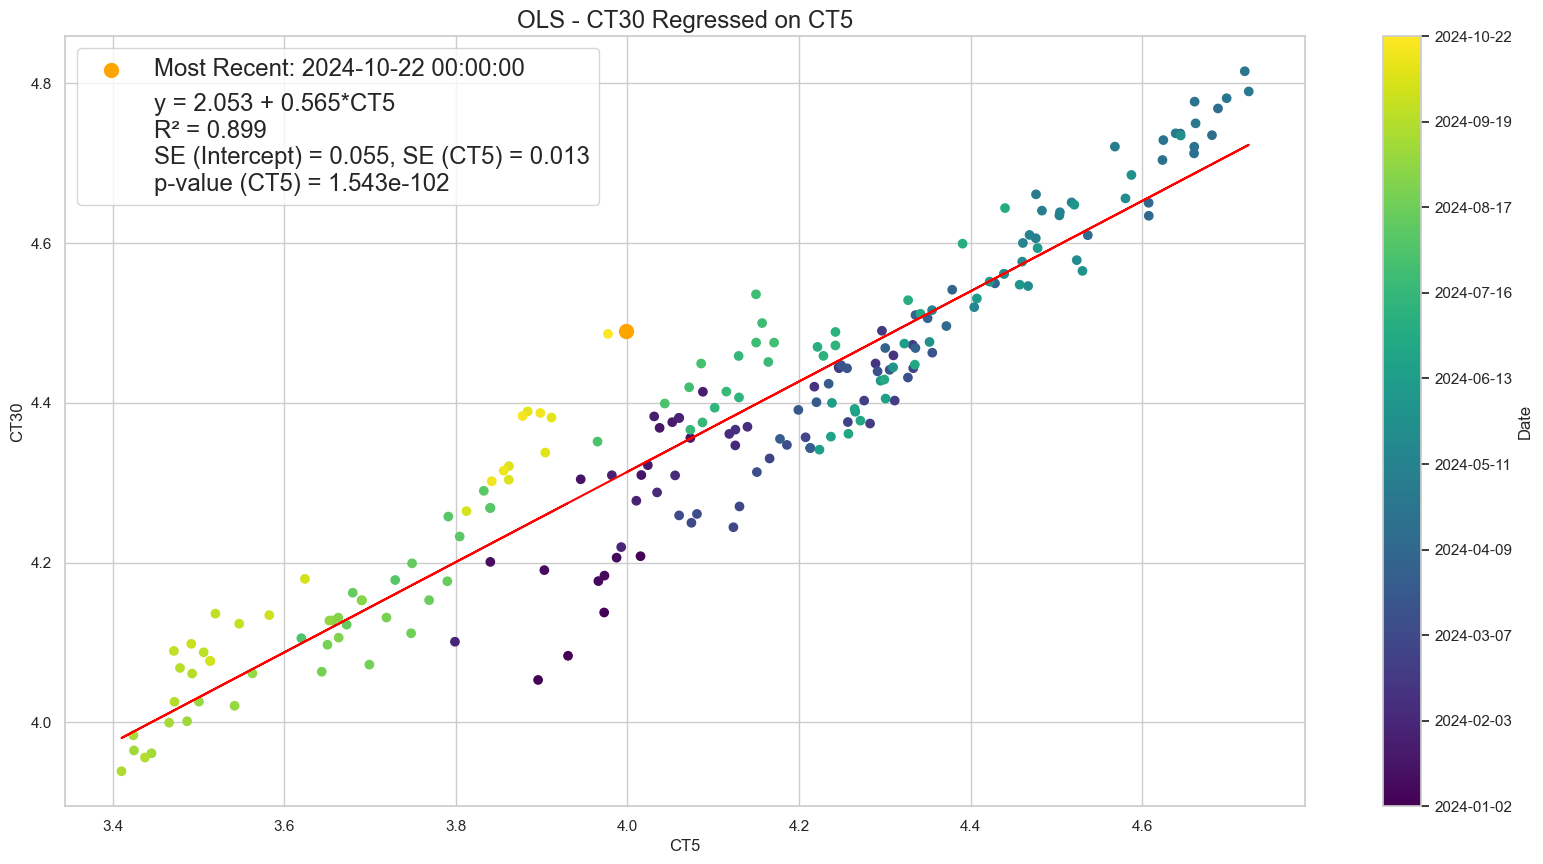

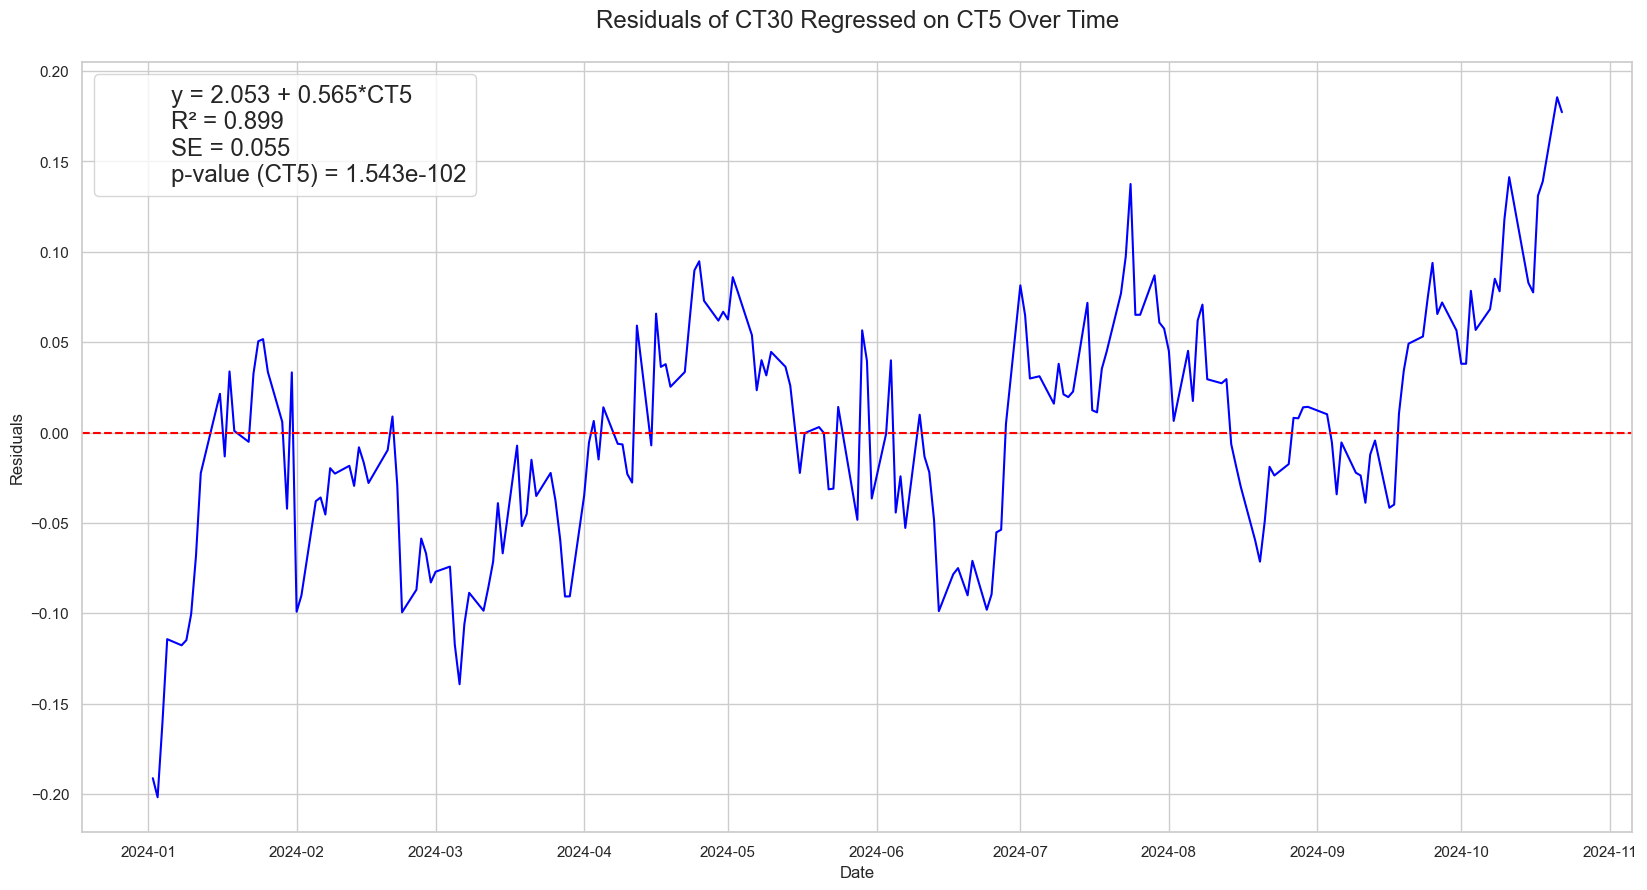

In [13]:
r = run_basic_linear_regression_df(df=ct_yields_df, x_col="CT5", y_col="CT30", date_color_bar=True, plot_most_recent=True, on_diff=False)
plot_residuals_timeseries(df=ct_yields_df, results=r, is_on_diff=False)
# r = run_basic_linear_regression_df(df=ct_yields_df, x_col="CT2", y_col="CT30", date_color_bar=True, on_diff=True, run_tls=True, plot_most_recent=True)
# plot_residuals_timeseries(df=ct_yields_df, results=r, is_on_diff=True)